# Preprocessing

We first import the packages we will use

In [1]:
import cellograph as cg
import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import phate
import meld

In [2]:
# Read in the normalized scRNA-seq data from Mead et al, 2022 downloaded from https://singlecell.broadinstitute.org (study SCP1318)
organa = sc.read("hu_org_KPT_normalized_expression_counts.csv.gz")
organa = organa.T
organa

AnnData object with n_obs × n_vars = 2484 × 14679

In [3]:
# Read in metadata
metadata = pd.read_csv("Hu_intest_metadata.csv", index_col = 0)
metadata

,array,treat,biosample_id,donor_id,cell_subset,sex,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label
NAME,,,,,,,,,,,,,,
GTCATCTAGATA,Sample_1,Ctrl,Ctrl-1,1,enterocyte,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
TTCAGAGACCCC,Sample_1,Ctrl,Ctrl-1,1,stem G2M,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
GTCCTTGAAGCG,Sample_1,Ctrl,Ctrl-1,1,enterocyte,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
ATTCGGATAGCG,Sample_1,Ctrl,Ctrl-4,3,enterocyte,male,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
CAGACTATAAAT,Sample_1,KPT,KPT-3,2,enterocyte,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAGGTCGTGCTA,Sample_3,Ctrl,Ctrl-1,1,DUOX2+ WAE-like,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
GTAAGAATAGTC,Sample_3,Ctrl,Ctrl-1,1,stem G1S,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well
TGCCTGTGGAAT,Sample_3,Ctrl,Ctrl-3,2,WAE-like,female,NCBITaxon_9606,Homo sapiens,PATO_0000461,normal,UBERON_0002114,duodenum,EFO_0008919,Seq-Well


In [4]:
treatment = list(metadata['treat'])
organa.obs['Treatment'] = treatment
organa.obs['Treatment'] = organa.obs['Treatment'].astype('category')
organa.obs['Treatment']

GTCATCTAGATA    Ctrl
TTCAGAGACCCC    Ctrl
GTCCTTGAAGCG    Ctrl
ATTCGGATAGCG    Ctrl
CAGACTATAAAT     KPT
                ... 
GAGGTCGTGCTA    Ctrl
GTAAGAATAGTC    Ctrl
TGCCTGTGGAAT    Ctrl
ACAGAGTATCGT    Ctrl
TTTGAGAGTCCT     KPT
Name: Treatment, Length: 2484, dtype: category
Categories (2, object): ['Ctrl', 'KPT']

In [5]:
cell_type = list(metadata['cell_subset'])
organa.obs['cell_type'] = cell_type
organa.obs['cell_type'] = organa.obs['cell_type'].astype('category')
organa.obs['cell_type']

GTCATCTAGATA         enterocyte
TTCAGAGACCCC           stem G2M
GTCCTTGAAGCG         enterocyte
ATTCGGATAGCG         enterocyte
CAGACTATAAAT         enterocyte
                     ...       
GAGGTCGTGCTA    DUOX2+ WAE-like
GTAAGAATAGTC           stem G1S
TGCCTGTGGAAT           WAE-like
ACAGAGTATCGT         progenitor
TTTGAGAGTCCT         progenitor
Name: cell_type, Length: 2484, dtype: category
Categories (9, object): ['DUOX2+ WAE-like', 'WAE-like', 'enterocyte', 'enteroendocrine', ..., 'progenitor', 'quiescent progenitor', 'stem G1S', 'stem G2M']

In [6]:
# Identify and filter the highly variable genes
sc.pp.highly_variable_genes(organa, min_mean=0.0125, max_mean=3, min_disp=0.5)
organa = organa[:, organa.var.highly_variable]
organa

View of AnnData object with n_obs × n_vars = 2484 × 1934
    obs: 'Treatment', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

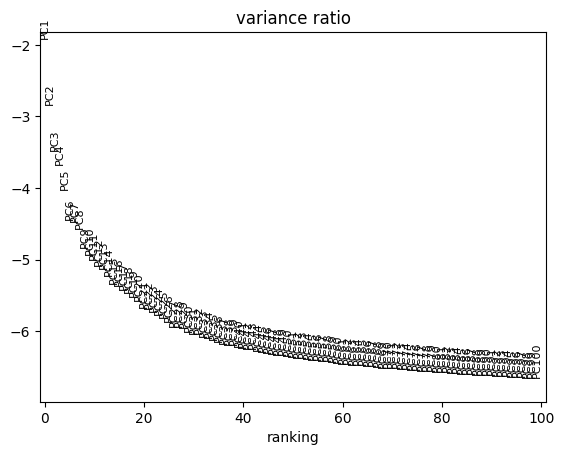

In [7]:
sc.tl.pca(organa, n_comps = 100, svd_solver = 'arpack')
sc.pl.pca_variance_ratio(organa, n_pcs = 100, log = True)

In [8]:
sc.pp.neighbors(organa, n_neighbors = 15, n_pcs = 60)

In [9]:
# Pull out the kNN
A = organa.obsp['connectivities']
labels = list(organa.obs['Treatment'].to_numpy())

In [10]:
organa

AnnData object with n_obs × n_vars = 2484 × 1934
    obs: 'Treatment', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Training the GNN

To train the GNN, we call cg.run_cellograph as follows, which outputs the single-cell probability of belonging to each condition, the latent space learned during training, and the gene-parameterized weight matrix

In [11]:
y_pred_all, softmax_gcn, activations, weights = cg.run_cellograph(organa, 
                                                                  labels = organa.obs['Treatment'], 
                                                                  num_classes = 2, 
                                                                  pcs = 60)

2023-02-23 15:20:58.273189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-23 15:20:58.365441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-23 15:20:58.365463: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-23 15:20:58.366592: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1934)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1934)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2484)]       0           []                               
                                                                                                  
 gcn_conv (GCNConv)             (None, 16)           30944       ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

1/1 [==============================] - 0s 69ms/step - loss: 0.0069 - acc: 0.9500 - val_loss: 0.0588 - val_acc: 0.8650
Epoch 49/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0068 - acc: 0.9000 - val_loss: 0.0557 - val_acc: 0.8900
Epoch 50/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0066 - acc: 0.9000 - val_loss: 0.0600 - val_acc: 0.8600
Epoch 51/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0065 - acc: 0.9500 - val_loss: 0.0545 - val_acc: 0.8850
Epoch 52/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0056 - acc: 0.9500 - val_loss: 0.0564 - val_acc: 0.8650
Epoch 53/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0084 - acc: 0.8750 - val_loss: 0.0597 - val_acc: 0.8500
Epoch 54/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0065 - acc: 0.9000 - val_loss: 0.0522 - val_acc: 0.8925
Epoch 55/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0061 - acc: 0.9250 - 

1/1 [==============================] - 0s 67ms/step - loss: 0.0051 - acc: 0.9250 - val_loss: 0.0511 - val_acc: 0.8775
Epoch 111/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0045 - acc: 0.9250 - val_loss: 0.0822 - val_acc: 0.7275
Epoch 112/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0061 - acc: 0.8250 - val_loss: 0.0508 - val_acc: 0.8900
Epoch 113/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0039 - acc: 0.9750 - val_loss: 0.0665 - val_acc: 0.8350
Epoch 114/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0054 - acc: 0.9000 - val_loss: 0.0533 - val_acc: 0.8650
Epoch 115/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0038 - acc: 0.9750 - val_loss: 0.0491 - val_acc: 0.8725
Epoch 116/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0034 - acc: 0.9750 - val_loss: 0.0574 - val_acc: 0.8475
Epoch 117/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0044 - acc: 0.

After training, we run PHATE on the latent space to visualize in lower dimensions

In [12]:
phate_operator = phate.PHATE()
x_phate = phate_operator.fit_transform(activations[3])
organa.obsm['X_phate'] = x_phate

Calculating PHATE...
  Running PHATE on 2484 observations and 16 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.10 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.26 seconds.
  Calculated landmark operator in 1.90 seconds.
  Calculating optimal t...
    Automatically selected t = 35
  Calculated optimal t in 0.98 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.58 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.17 seconds.
Calculated PHATE in 6.73 seconds.


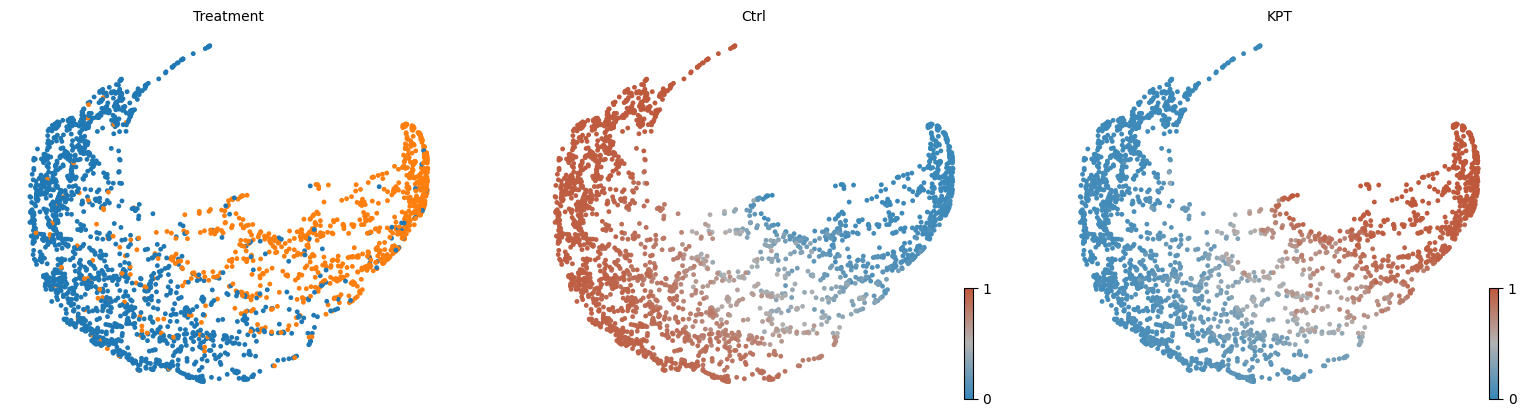

In [13]:
cg.plot_phate(organa, groups = ['Treatment', 'Ctrl', 'KPT'])

We can also make a heatmap of the top 25 weighted genes from the learned weight matrix, telling us which genes were most informative in distinguishing between conditions

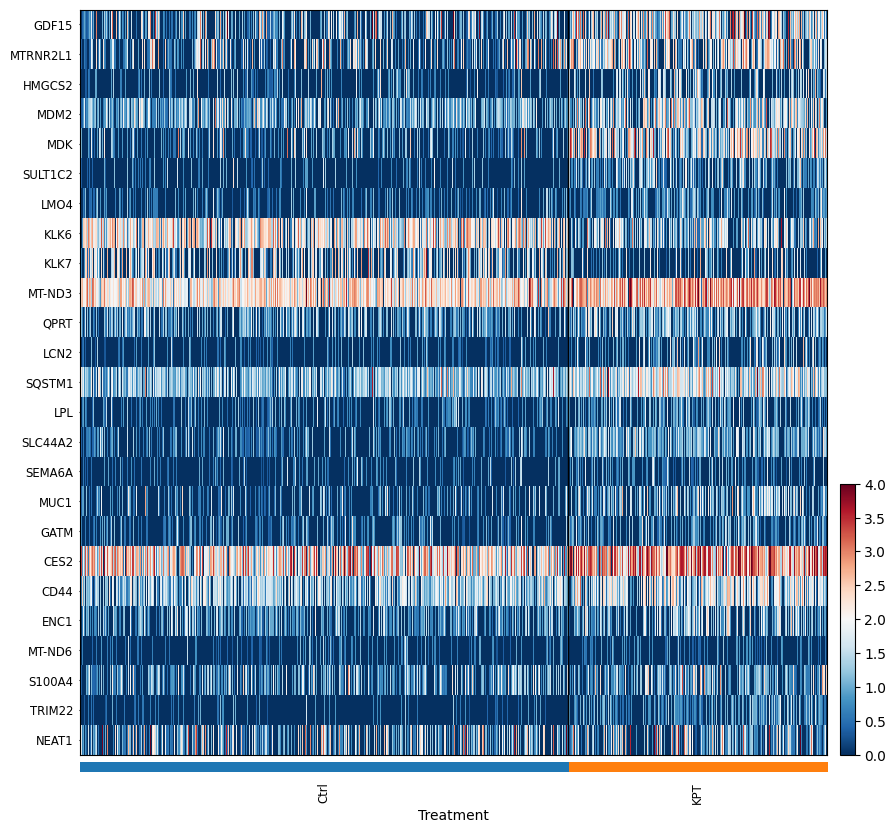

In [16]:
cg.plot_weight_matrix(organa, weights = weights, vmin = 0, vmax = 4)